# Log Evaluation for Unit Test Generation

In [62]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
# get filepaths for all files in logs folder

filepaths = []
for root, dirs, files in os.walk("logs"):
    for file in files:
        if file.endswith(".csv"):
            filepaths.append(os.path.join(root, file))

In [64]:
# read each file into a seperate dataframe

dataframes = []
for filepath in filepaths:
    dataframes.append(pd.read_csv(filepath, delimiter=";", header=0,
                                  names=["project_name", "method_id", "event", "result_code", "add_info"]))
    # add column containing filename
    dataframes[-1]["file"] = os.path.basename(filepath)

In [65]:
dataframes[0]

,project_name,method_id,event,result_code,add_info,file
0,commons-cli-master,33,Class Name Extraction Error,1,NaN,20231022_041614.csv
1,commons-cli-master,25,Compilation Successful Round 0,0,NaN,20231022_041614.csv
2,commons-cli-master,61,Compilation Successful Round 0,0,NaN,20231022_041614.csv
3,commons-cli-master,5,Class Name Extraction Error,1,NaN,20231022_041614.csv
4,commons-cli-master,6,Other Error,1,name 'method_id' is not defined,20231022_041614.csv
...,...,...,...,...,...,...
126,commons-cli-master,113,Other Error,1,0,20231022_041614.csv
127,commons-cli-master,117,Other Error,1,0,20231022_041614.csv
128,commons-cli-master,121,Other Error,1,0,20231022_041614.csv
129,commons-cli-master,84,Other Error,1,0,20231022_041614.csv


In [66]:
# create another dataframe for each of the dataframes to save statistics
# the following statics are needed:
# - number of unique methods
# - ids of missing test cases (method_id), in theory all method_ids between 1 and 230 should be present
# - successful in each compilation round (event == Compilation Successful Round X) for rounds 0 to 3
# - number of successful compilations (event == Compilation Successful Round X)
# - number of failed compilations (event == Compilation Error Round 3)
#
stats_list = []

for dataframe in dataframes:
    if len(dataframe) == 0:
        continue

    # print df name
    n_unique = len(dataframe["method_id"].unique())

    missing_methods = np.setdiff1d(np.arange(1, 231), dataframe["method_id"].unique())
    succ_comp_round_0 = (dataframe["event"] == "Compilation Successful Round 0").sum()
    succ_comp_round_1 = (dataframe["event"] == "Compilation Successful Round 1").sum()
    succ_comp_round_2 = (dataframe["event"] == "Compilation Successful Round 2").sum()
    succ_comp_round_3 = (dataframe["event"] == "Compilation Successful Round 3").sum()

    rel_succ_comp_round_0 = succ_comp_round_0 / n_unique
    rel_succ_comp_round_1 = succ_comp_round_1 / n_unique
    rel_succ_comp_round_2 = succ_comp_round_2 / n_unique
    rel_succ_comp_round_3 = succ_comp_round_3 / n_unique

    total_succ_comp = succ_comp_round_0 + succ_comp_round_1 + succ_comp_round_2 + succ_comp_round_3
    rel_total_succ_comp = total_succ_comp / n_unique

    comp_repair_prompt_construct_err_round_1 = (
            dataframe["event"] == "Compilation Repair Prompt Construction Error Round 1").sum()
    comp_repair_prompt_construct_err_round_2 = (
            dataframe["event"] == "Compilation Repair Prompt Construction Error Round 2").sum()
    comp_repair_prompt_construct_err_round_3 = (
            dataframe["event"] == "Compilation Repair Prompt Construction Error Round 3").sum()

    rel_comp_repair_prompt_construct_err_round_1 = comp_repair_prompt_construct_err_round_1 / n_unique
    rel_comp_repair_prompt_construct_err_round_2 = comp_repair_prompt_construct_err_round_2 / n_unique
    rel_comp_repair_prompt_construct_err_round_3 = comp_repair_prompt_construct_err_round_3 / n_unique

    class_name_extraction_error = (dataframe["event"] == "Class Name Extraction Error").sum()
    no_source_code_error = (dataframe["add_info"] == "name 'method_id' is not defined").sum()
    timeout_errors = (dataframe["add_info"] == "Timed Out").sum()
    other_errors = (dataframe["event"] == "Other Error").sum() - timeout_errors - no_source_code_error

    rel_class_name_extraction_error = class_name_extraction_error / n_unique
    rel_no_source_code_error = no_source_code_error / n_unique
    rel_timeout_errors = timeout_errors / n_unique
    rel_other_errors = other_errors / n_unique

    failed_comp = (dataframe["event"] == "Compilation Error Round 3").sum()
    rel_failed_comp = failed_comp / n_unique

    # EXECUTION RESULTS
    succ_exec_round_0 = (dataframe["event"] == "Execution Successful after 0 repairs").sum()
    succ_exec_round_1 = (dataframe["event"] == "Execution Successful after 1 repairs").sum()
    succ_exec_round_2 = (dataframe["event"] == "Execution Successful after 2 repairs").sum()

    rel_succ_exec_round_0 = succ_exec_round_0 / n_unique
    rel_succ_exec_round_1 = succ_exec_round_1 / n_unique
    rel_succ_exec_round_2 = succ_exec_round_2 / n_unique

    rel_to_comp_succ_exec_round_0 = succ_exec_round_0 / total_succ_comp
    rel_to_comp_succ_exec_round_1 = succ_exec_round_1 / total_succ_comp
    rel_to_comp_succ_exec_round_2 = succ_exec_round_2 / total_succ_comp

    total_succ_exec = succ_exec_round_0 + succ_exec_round_1 + succ_exec_round_2
    rel_total_succ_exec = total_succ_exec / n_unique
    rel_to_comp_succ_exec = total_succ_exec / total_succ_comp

    # add to a dataframe
    stats = pd.DataFrame({"project_name": [dataframe["project_name"][0]],
                          "file": [dataframe["file"][0]],
                          "n_unique": [n_unique],
                          "missing_methods": [missing_methods],
                          "succ_comp_round_0": [succ_comp_round_0],
                          "succ_comp_round_1": [succ_comp_round_1],
                          "succ_comp_round_2": [succ_comp_round_2],
                          "succ_comp_round_3": [succ_comp_round_3],
                          "rel_succ_comp_round_0": [rel_succ_comp_round_0],
                          "rel_succ_comp_round_1": [rel_succ_comp_round_1],
                          "rel_succ_comp_round_2": [rel_succ_comp_round_2],
                          "rel_succ_comp_round_3": [rel_succ_comp_round_3],
                          "total_succ_comp": [total_succ_comp],
                          "rel_total_succ_comp": [rel_total_succ_comp],
                          "comp_repair_prompt_construct_err_round_1": [comp_repair_prompt_construct_err_round_1],
                          "comp_repair_prompt_construct_err_round_2": [comp_repair_prompt_construct_err_round_2],
                          "comp_repair_prompt_construct_err_round_3": [comp_repair_prompt_construct_err_round_3],
                          "rel_comp_repair_prompt_construct_err_round_1": [
                              rel_comp_repair_prompt_construct_err_round_1],
                          "rel_comp_repair_prompt_construct_err_round_2": [
                              rel_comp_repair_prompt_construct_err_round_2],
                          "rel_comp_repair_prompt_construct_err_round_3": [
                              rel_comp_repair_prompt_construct_err_round_3],
                          "class_name_extraction_error": [class_name_extraction_error],
                          "no_source_code_error": [no_source_code_error],
                          "timeout_errors": [timeout_errors],
                          "other_errors": [other_errors],
                          "rel_class_name_extraction_error": [rel_class_name_extraction_error],
                          "rel_no_source_code_error": [rel_no_source_code_error],
                          "rel_timeout_errors": [rel_timeout_errors],
                          "rel_other_errors": [rel_other_errors],
                          "failed_comp": [failed_comp],
                          "rel_failed_comp": [rel_failed_comp],
                          "succ_exec_round_0": [succ_exec_round_0],
                          "succ_exec_round_1": [succ_exec_round_1],
                          "succ_exec_round_2": [succ_exec_round_2],
                          "rel_succ_exec_round_0": [rel_succ_exec_round_0],
                          "rel_succ_exec_round_1": [rel_succ_exec_round_1],
                          "rel_succ_exec_round_2": [rel_succ_exec_round_2],
                          "rel_to_comp_succ_exec_round_0": [rel_to_comp_succ_exec_round_0],
                          "rel_to_comp_succ_exec_round_1": [rel_to_comp_succ_exec_round_1],
                          "rel_to_comp_succ_exec_round_2": [rel_to_comp_succ_exec_round_2],
                          "total_succ_exec": [total_succ_exec],
                          "rel_total_succ_exec": [rel_total_succ_exec],
                          "rel_to_comp_succ_exec": [rel_to_comp_succ_exec]
                          })
    stats_list.append(stats)

/var/folders/0g/czf1jpd15jx1w6btr565xw180000gn/T/ipykernel_70744/266283772.py:65: RuntimeWarning: invalid value encountered in scalar divide
  rel_to_comp_succ_exec_round_0 = succ_exec_round_0 / total_succ_comp
/var/folders/0g/czf1jpd15jx1w6btr565xw180000gn/T/ipykernel_70744/266283772.py:66: RuntimeWarning: invalid value encountered in scalar divide
  rel_to_comp_succ_exec_round_1 = succ_exec_round_1 / total_succ_comp
/var/folders/0g/czf1jpd15jx1w6btr565xw180000gn/T/ipykernel_70744/266283772.py:67: RuntimeWarning: invalid value encountered in scalar divide
  rel_to_comp_succ_exec_round_2 = succ_exec_round_2 / total_succ_comp
/var/folders/0g/czf1jpd15jx1w6btr565xw180000gn/T/ipykernel_70744/266283772.py:71: RuntimeWarning: invalid value encountered in scalar divide
  rel_to_comp_succ_exec = total_succ_exec / total_succ_comp


In [67]:
# combine all the statistics in one dataframe
stats_df = pd.concat(stats_list, ignore_index=True)

In [68]:
stats_df

,project_name,file,n_unique,missing_methods,succ_comp_round_0,succ_comp_round_1,succ_comp_round_2,succ_comp_round_3,rel_succ_comp_round_0,rel_succ_comp_round_1,...,succ_exec_round_2,rel_succ_exec_round_0,rel_succ_exec_round_1,rel_succ_exec_round_2,rel_to_comp_succ_exec_round_0,rel_to_comp_succ_exec_round_1,rel_to_comp_succ_exec_round_2,total_succ_exec,rel_total_succ_exec,rel_to_comp_succ_exec
0,commons-cli-master,20231022_041614.csv,91,"[70, 71, 72, 76, 78, 79, 80, 86, 87, 88, 91, 9...",21,9,0,1,0.230769,0.098901,...,0,0.109890,0.054945,0.000000,0.322581,0.161290,0.000000,15,0.164835,0.483871
1,commons-cli-master,20231025_193245.csv,230,[],57,26,7,12,0.247826,0.113043,...,1,0.100000,0.026087,0.004348,0.225490,0.058824,0.009804,30,0.130435,0.294118
2,commons-cli-master,20231025_105031.csv,230,[],55,31,8,4,0.239130,0.134783,...,4,0.156522,0.013043,0.017391,0.367347,0.030612,0.040816,43,0.186957,0.438776
3,commons-cli-master,20231025_183916.csv,230,[],51,22,18,9,0.221739,0.095652,...,1,0.126087,0.017391,0.004348,0.290000,0.040000,0.010000,34,0.147826,0.340000
4,commons-cli-master,20231024_114151.csv,227,"[24, 172, 200]",31,9,6,1,0.136564,0.039648,...,0,0.057269,0.004405,0.000000,0.276596,0.021277,0.000000,14,0.061674,0.297872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,commons-cli-master,20231023_195751.csv,230,[],56,26,15,6,0.243478,0.113043,...,0,0.117391,0.034783,0.000000,0.262136,0.077670,0.000000,35,0.152174,0.339806
90,commons-cli-master,20231024_080105.csv,230,[],58,31,14,6,0.252174,0.134783,...,2,0.152174,0.021739,0.008696,0.321101,0.045872,0.018349,42,0.182609,0.385321
91,commons-cli-master,20231026_022739.csv,15,"[2, 3, 4, 6, 7, 8, 10, 11, 12, 14, 15, 16, 18,...",6,2,0,1,0.400000,0.133333,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
92,commons-cli-master,20231023_195155.csv,2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0,0,0,0,0.000000,0.000000,...,0,0.000000,0.000000,0.000000,NaN,NaN,NaN,0,0.000000,NaN


In [69]:
stats_df[(stats_df["n_unique"] == 230) & (stats_df["other_errors"] < 9) & (stats_df["timeout_errors"] < 10)]

,project_name,file,n_unique,missing_methods,succ_comp_round_0,succ_comp_round_1,succ_comp_round_2,succ_comp_round_3,rel_succ_comp_round_0,rel_succ_comp_round_1,...,succ_exec_round_2,rel_succ_exec_round_0,rel_succ_exec_round_1,rel_succ_exec_round_2,rel_to_comp_succ_exec_round_0,rel_to_comp_succ_exec_round_1,rel_to_comp_succ_exec_round_2,total_succ_exec,rel_total_succ_exec,rel_to_comp_succ_exec
1,commons-cli-master,20231025_193245.csv,230,[],57,26,7,12,0.247826,0.113043,...,1,0.100000,0.026087,0.004348,0.225490,0.058824,0.009804,30,0.130435,0.294118
2,commons-cli-master,20231025_105031.csv,230,[],55,31,8,4,0.239130,0.134783,...,4,0.156522,0.013043,0.017391,0.367347,0.030612,0.040816,43,0.186957,0.438776
3,commons-cli-master,20231025_183916.csv,230,[],51,22,18,9,0.221739,0.095652,...,1,0.126087,0.017391,0.004348,0.290000,0.040000,0.010000,34,0.147826,0.340000
5,commons-cli-master,20231028_042634.csv,230,[],62,22,13,8,0.269565,0.095652,...,2,0.165217,0.013043,0.008696,0.361905,0.028571,0.019048,43,0.186957,0.409524
9,commons-cli-master,20231024_004630.csv,230,[],56,26,17,9,0.243478,0.113043,...,4,0.117391,0.030435,0.017391,0.250000,0.064815,0.037037,38,0.165217,0.351852
10,commons-cli-master,20231024_091429.csv,230,[],63,31,12,7,0.273913,0.134783,...,0,0.165217,0.013043,0.000000,0.336283,0.026549,0.000000,41,0.178261,0.362832
18,commons-cli-master,20231030_094427.csv,230,[],67,19,14,6,0.291304,0.082609,...,1,0.147826,0.030435,0.004348,0.320755,0.066038,0.009434,42,0.182609,0.396226
21,commons-cli-master,20231028_052637.csv,230,[],47,28,11,11,0.204348,0.121739,...,2,0.134783,0.017391,0.008696,0.319588,0.041237,0.020619,37,0.160870,0.381443
25,commons-cli-master,20231026_155023.csv,230,[],57,25,13,10,0.247826,0.108696,...,3,0.139130,0.013043,0.013043,0.304762,0.028571,0.028571,38,0.165217,0.361905
26,commons-cli-master,20231025_125643.csv,230,[],51,28,10,11,0.221739,0.121739,...,1,0.139130,0.026087,0.004348,0.320000,0.060000,0.010000,39,0.169565,0.390000


In [70]:
all_stats = stats_df.copy()
stats_df = stats_df[(stats_df["n_unique"] == 230) & (stats_df["other_errors"] < 9) & (stats_df["timeout_errors"] < 10)]
stats_df = stats_df.sort_values('file').reset_index(drop=True)
stats_df.to_csv('valid_runs.csv')

In [71]:
def plot_succ_comp_per_round(df, sample=5):
    df = stats_df.reset_index()
    # select a random samples from rows based on "sample" parameter
    df = df.sample(sample)
    df = df[["index", "succ_comp_round_0", "succ_comp_round_1", "succ_comp_round_2", "succ_comp_round_3"]]
    df = df.rename(
        columns={"index": "Run", "succ_comp_round_0": "Initial Compilation", "succ_comp_round_1": "Repair Round 1",
                 "succ_comp_round_2": "Repair Round 2", "succ_comp_round_3": "Repair Round 3"})

    sns.set_style("whitegrid")

    # Melt the DataFrame to reorganize the data for the barplot
    df_melted = pd.melt(df, id_vars=['Run'], var_name='Round', value_name='Success')

    # Create a grouped barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_melted, x='Run', y='Success', hue='Round', palette="Set3")
    plt.xlabel('Run')
    plt.ylabel('Successful Compilation')
    plt.title('Grouped Barplot of Successful Compilation by Round')
    plt.legend(title='Round', loc='upper right')
    plt.show()


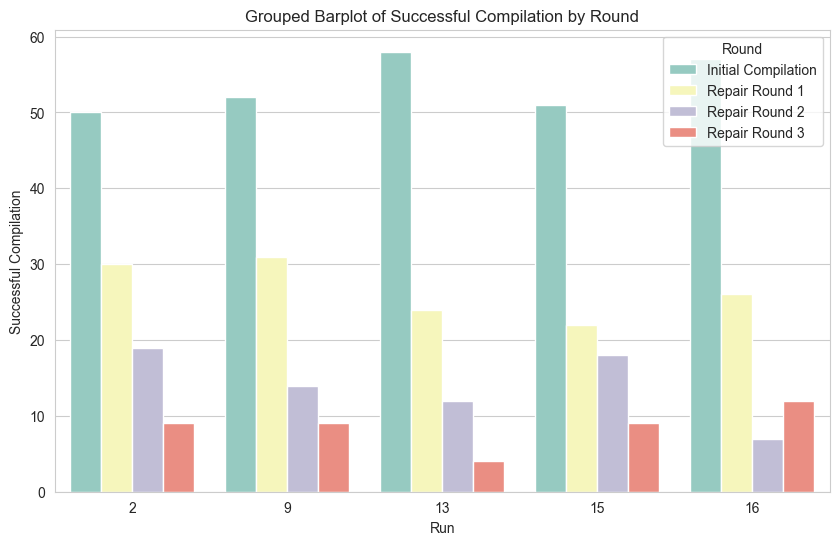

In [72]:
plot_succ_comp_per_round(stats_df)

In [73]:
def plot_succ_comp_per_round_boxplot(df):
    df = stats_df.reset_index()
    df = df[["index", "succ_comp_round_0", "succ_comp_round_1", "succ_comp_round_2", "succ_comp_round_3"]]
    df = df.rename(
        columns={"index": "Run", "succ_comp_round_0": "Initial Compilation", "succ_comp_round_1": "Repair Round 1",
                 "succ_comp_round_2": "Repair Round 2", "succ_comp_round_3": "Repair Round 3"})

    sns.set_style("whitegrid")

    # Melt the DataFrame to reorganize the data for the barplot
    df_melted = pd.melt(df, id_vars=['Run'], var_name='Round', value_name='Success')

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_melted, x='Round', y='Success', palette="Set3", hue="Round", legend=False)
    plt.xlabel('Round')
    plt.ylabel('Successfully compiled test classes')
    plt.title('Successful Compilation by Repair Round')
    plt.savefig("succ_comp_per_round_boxplot.png")
    plt.show()

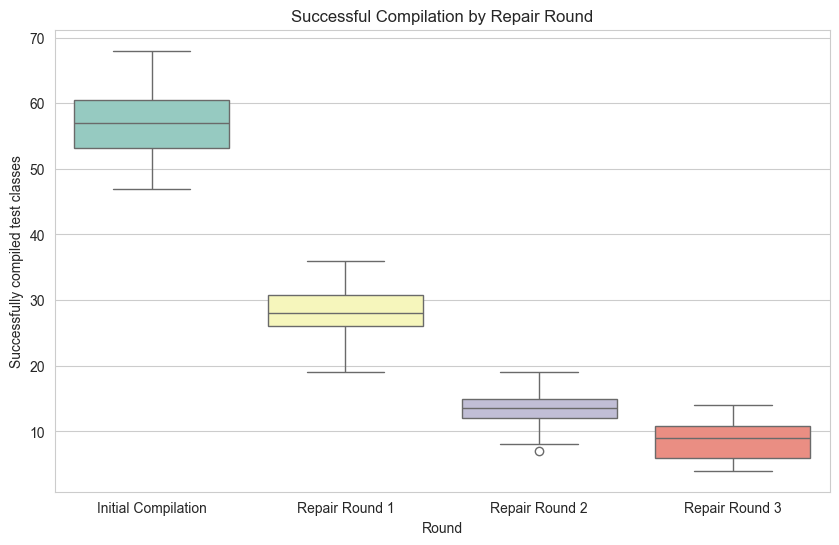

In [74]:
plot_succ_comp_per_round_boxplot(stats_df)

In [75]:
def plot_succ_exec_per_round_boxplot(df):
    df = stats_df.reset_index()
    df = df[["index", "succ_exec_round_0", "succ_exec_round_1", "succ_exec_round_2"]]
    df = df.rename(
        columns={"index": "Run", "succ_exec_round_0": "Initial Execution", "succ_exec_round_1": "Repair Round 1",
                 "succ_exec_round_2": "Repair Round 2"})

    sns.set_style("whitegrid")

    # Melt the DataFrame to reorganize the data for the barplot
    df_melted = pd.melt(df, id_vars=['Run'], var_name='Round', value_name='Success')

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_melted, x='Round', y='Success', palette="Set3", hue="Round", legend=False)
    plt.xlabel('Round')
    plt.ylabel('Successfully executed test classes')
    plt.title('Successful Execution by Repair Round')
    plt.savefig("succ_exec_per_round_boxplot.png")
    plt.show()

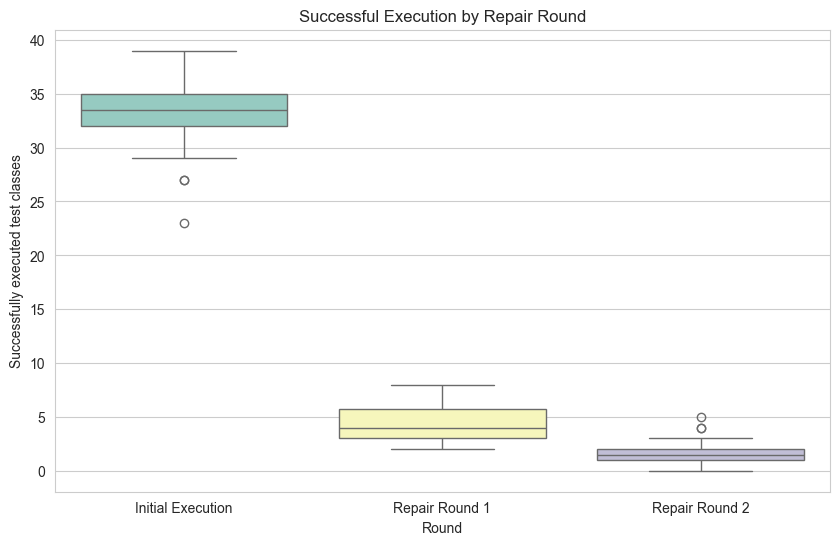

In [76]:
plot_succ_exec_per_round_boxplot(stats_df)

In [77]:
# create dataframe compiling relevent statistics

# - average successful compilations per round and total
# - average successful executions per round and total
# - standard deviations
# include percentage of total

# desc | value | std | perc_of_total
# succ_comp_round_0 | 0.0 | 0.0 | 0.0
# succ_comp_round_1 | 0.0 | 0.0 | 0.0
# succ_comp_round_2 | 0.0 | 0.0 | 0.0
# succ_comp_round_3 | 0.0 | 0.0 | 0.0
# total_succ_comp | 0.0 | 0.0 | 0.0
# succ_exec_round_0 | 0.0 | 0.0 | 0.0
# succ_exec_round_1 | 0.0 | 0.0 | 0.0
# succ_exec_round_2 | 0.0 | 0.0 | 0.0
# total_succ_exec | 0.0 | 0.0 | 0.0

statistics_overview = pd.DataFrame(
    {'desc': ["succ_comp_round_0", "succ_comp_round_1", "succ_comp_round_2", "succ_comp_round_3",
              "total_succ_comp", "succ_exec_round_0", "succ_exec_round_1", "succ_exec_round_2",
              "total_succ_exec"],
     'value': [stats_df["succ_comp_round_0"].mean(), stats_df["succ_comp_round_1"].mean(),
               stats_df["succ_comp_round_2"].mean(), stats_df["succ_comp_round_3"].mean(),
               stats_df["total_succ_comp"].mean(), stats_df["succ_exec_round_0"].mean(),
               stats_df["succ_exec_round_1"].mean(), stats_df["succ_exec_round_2"].mean(),
               stats_df["total_succ_exec"].mean()],
     'std': [stats_df["succ_comp_round_0"].std(), stats_df["succ_comp_round_1"].std(),
             stats_df["succ_comp_round_2"].std(), stats_df["succ_comp_round_3"].std(),
             stats_df["total_succ_comp"].std(), stats_df["succ_exec_round_0"].std(),
             stats_df["succ_exec_round_1"].std(), stats_df["succ_exec_round_2"].std(),
             stats_df["total_succ_exec"].std()],
     'perc_of_total': [stats_df["succ_comp_round_0"].mean() / stats_df["total_succ_comp"].mean(),
                       stats_df["succ_comp_round_1"].mean() / stats_df["total_succ_comp"].mean(),
                       stats_df["succ_comp_round_2"].mean() / stats_df["total_succ_comp"].mean(),
                       stats_df["succ_comp_round_3"].mean() / stats_df["total_succ_comp"].mean(),
                       stats_df["total_succ_comp"].mean() / stats_df["total_succ_comp"].mean(),
                       stats_df["succ_exec_round_0"].mean() / stats_df["total_succ_exec"].mean(),
                       stats_df["succ_exec_round_1"].mean() / stats_df["total_succ_exec"].mean(),
                       stats_df["succ_exec_round_2"].mean() / stats_df["total_succ_exec"].mean(),
                       stats_df["total_succ_exec"].mean() / stats_df["total_succ_exec"].mean()]
     })

In [78]:
statistics_overview

,desc,value,std,perc_of_total
0,succ_comp_round_0,57.133333,5.550603,0.534123
1,succ_comp_round_1,28.000000,3.859605,0.261764
2,succ_comp_round_2,13.266667,2.958720,0.124026
3,succ_comp_round_3,8.566667,2.884959,0.080087
4,total_succ_comp,106.966667,7.126847,1.000000
5,succ_exec_round_0,33.033333,3.528049,0.850644
6,succ_exec_round_1,4.200000,1.954658,0.108155
7,succ_exec_round_2,1.600000,1.275769,0.041202
8,total_succ_exec,38.833333,3.333046,1.000000


In [79]:
# create statistics involving all values

# for compilation:
# | desc | value | rel |
# | total_methods | 0 | 1 |
# | succ_comp_round_0 | 0 | 0.0 |
# | succ_comp_round_1 | 0 | 0.0 |
# | succ_comp_round_2 | 0 | 0.0 |
# | succ_comp_round_3 | 0 | 0.0 |
# | total_succ_comp | 0 | 0.0 |

# for errors:
# | desc | value | rel |
# | total_methods | 0 | 1 |
# | class_name_extraction_error | 0 | 0.0 |
# | no_source_code_error | 0 | 0.0 |
# | timeout_errors | 0 | 0.0 |
# | other_errors | 0 | 0.0 |
# | total_errors | 0 | 0.0 |

# for execution:
# | desc | value | rel |
# | total_methods | 0 | 1 |
# | succ_exec_round_0 | 0 | 0.0 |
# | succ_exec_round_1 | 0 | 0.0 |
# | succ_exec_round_2 | 0 | 0.0 |
# | total_succ_exec | 0 | 0.0 |

# for compilation:
compilation_total_stat = pd.DataFrame(
    {'desc': ["total_methods", "succ_comp_round_0", "succ_comp_round_1", "succ_comp_round_2",
              "succ_comp_round_3", "total_succ_comp"],
     'value': [stats_df["n_unique"].sum(), stats_df["succ_comp_round_0"].sum(),
               stats_df["succ_comp_round_1"].sum(), stats_df["succ_comp_round_2"].sum(),
               stats_df["succ_comp_round_3"].sum(), stats_df["total_succ_comp"].sum()],
     'rel': [1, stats_df["succ_comp_round_0"].sum() / stats_df["n_unique"].sum(),
             stats_df["succ_comp_round_1"].sum() / stats_df["n_unique"].sum(),
             stats_df["succ_comp_round_2"].sum() / stats_df["n_unique"].sum(),
             stats_df["succ_comp_round_3"].sum() / stats_df["n_unique"].sum(),
             stats_df["total_succ_comp"].sum() / stats_df["n_unique"].sum()]
     })

# for errors:
errors_total_stat = pd.DataFrame({'desc': ["total_methods", "class_name_extraction_error", "no_source_code_error",
                                           "timeout_errors", "other_errors", "total_errors"],
                                  'value': [stats_df["n_unique"].sum(), stats_df["class_name_extraction_error"].sum(),
                                            stats_df["no_source_code_error"].sum(), stats_df["timeout_errors"].sum(),
                                            stats_df["other_errors"].sum(),
                                            (stats_df["class_name_extraction_error"].sum() +
                                             stats_df["no_source_code_error"].sum() + stats_df["timeout_errors"].sum() +
                                             stats_df["other_errors"].sum())],
                                  'rel': [1, stats_df["class_name_extraction_error"].sum() / stats_df["n_unique"].sum(),
                                          stats_df["no_source_code_error"].sum() / stats_df["n_unique"].sum(),
                                          stats_df["timeout_errors"].sum() / stats_df["n_unique"].sum(),
                                          stats_df["other_errors"].sum() / stats_df["n_unique"].sum(),
                                          (stats_df["class_name_extraction_error"].sum() +
                                           stats_df["no_source_code_error"].sum() + stats_df["timeout_errors"].sum() +
                                           stats_df["other_errors"].sum()) / stats_df["n_unique"].sum()]
                                  })


# for execution:
execution_total_stat = pd.DataFrame(
    {'desc': ["total_methods", "succ_exec_round_0", "succ_exec_round_1", "succ_exec_round_2", "total_succ_exec"],
     'value': [stats_df["n_unique"].sum(), stats_df["succ_exec_round_0"].sum(), stats_df["succ_exec_round_1"].sum(),
               stats_df["succ_exec_round_2"].sum(), stats_df["total_succ_exec"].sum()],
     'rel': [1, stats_df["succ_exec_round_0"].sum() / stats_df["n_unique"].sum(),
             stats_df["succ_exec_round_1"].sum() / stats_df["n_unique"].sum(),
             stats_df["succ_exec_round_2"].sum() / stats_df["n_unique"].sum(),
                stats_df["total_succ_exec"].sum() / stats_df["n_unique"].sum()],
        })

In [80]:
compilation_total_stat

,desc,value,rel
0,total_methods,6900,1.000000
1,succ_comp_round_0,1714,0.248406
2,succ_comp_round_1,840,0.121739
3,succ_comp_round_2,398,0.057681
4,succ_comp_round_3,257,0.037246
5,total_succ_comp,3209,0.465072


In [81]:
execution_total_stat

,desc,value,rel
0,total_methods,6900,1.000000
1,succ_exec_round_0,991,0.143623
2,succ_exec_round_1,126,0.018261
3,succ_exec_round_2,48,0.006957
4,total_succ_exec,1165,0.168841


In [82]:
errors_total_stat

,desc,value,rel
0,total_methods,6900,1.000000
1,class_name_extraction_error,501,0.072609
2,no_source_code_error,282,0.040870
3,timeout_errors,0,0.000000
4,other_errors,24,0.003478
5,total_errors,807,0.116957
